## <center> Port Elizabeth Crime Forecasting (2010-2023)
### <center> Anil Abraham 2023

#### <center> The goal of this project is to use machine learning techniques to forecast crime in Port Elizabeth. Particularly, forecasting type of crime, number of crimes committed in a year, and crime hotspots/locations.

#### Brief explanation of each column:
<ul>
<li>Crime - Description of crime committed</li>
<li>Crimes - Number of crimes committed per year</li>
<li>Police Station - Name of Police Station within Port Elizabeth</li>
<li>Province - Name of province</li>
<li>Crime Category - Binning of crime descriptions</li>
<li>Latitude/Longitude/Latitude, Longitude - Location</li>
<li>Year - Year crimes took place</li>
</ul>

#### Police stations within Port Elizabeth are:
<ul>
<li>Walmer</li>
<li>Swartkops</li>
<li>Mount Road</li>
<li>Humewood</li>
<li>Kwadwesi</li>
<li>Kabega Park</li>
<li>Algoapark</li>
<li>Gelvandale</li>
<li>Bethelsdorp</li>
<li>Motherwell</li>
<li>New Brighton</li>
<li>Kwazakele</li>
</ul>

### <u>Importing libraries</u>

In [3]:
import pandas as pd #Pandas for data manipulation and analysis
import numpy as np #Numpy for matrices
import geopandas as gpd #Support for geospatial data
from shapely.geometry import Point #Geographic information systems functions and analysis
import matplotlib.pyplot as plt #Matplotlib for visualisations
import seaborn as sns
import plotly.express as px
sns.set_style("darkgrid")

### <u>Loading dataset</u>

In [4]:
df = pd.read_csv('crimedata.csv', thousands=',') #Thousands are seperated by commas in the CSV.

for col in df.columns.to_list(): #List all feature names
    print(col)
df.shape

Crime
Crimes
Police Station
Province
Crime Category
Latitude
Longitude
Latitude, Longitude
Year


(346470, 9)

### <u>Data preprocessing</u>

#### Limit to PE only

In [5]:
stations = ["Walmer", "Swartkops", "New Brighton", "Mount Road", "Humewood", "Kwadwesi", "Kabega Park", "Algoapark", "Gelvandale", "Bethelsdorp", "Motherwell"
            , "Kwazakele", "Ikamvelihle"] #Police stations existing within Port Elizabeth
df = df[df['Police Station'].isin(stations)].reset_index(drop=True) #Filtering

In [6]:
df[df['Year'] == 2022]['Crimes'].sum()

35982

#### Drop 'Latitude,Longitude' and 'Province'

In [7]:
df.drop(['Latitude, Longitude', 'Province'], axis=1, inplace=True) #Drop redundant information

#### Other fixes

In [8]:
df = df[df['Police Station'] != 'Doringkloof'] #'Doringkloof' does not exist within the Eastern Cape, but within Gauteng. Remove this.

df.loc[df['Police Station'] == 'Kwazakele', 'Latitude'] = -33.87626 #Kwazekele's lat/long coords are wrong. Fix it.
df.loc[df['Police Station'] == 'Kwazakele', 'Longitude'] = 25.58308

#### Check for null values

In [9]:
print(f'Null values found\n{df.isna().sum()}') #Check for null values

Null values found
Crime             0
Crimes            0
Police Station    0
Crime Category    0
Latitude          0
Longitude         0
Year              0
dtype: int64


#### Check for duplicates

In [10]:
print(f'Before checking for duplicates\n{df.duplicated().sum()}')
df.drop_duplicates(inplace=True) #Drop all duplicates
print(f'\nAfter checking for duplicates\n{df.duplicated().sum()}')

Before checking for duplicates
0

After checking for duplicates
0


#### Convert to categorical

In [11]:
# df['Crime'] = pd.Categorical(df['Crime']) #Convert categorical columns to pd.Categorical()
# df['Police Station'] = pd.Categorical(df['Police Station'])
# df['Crime Category'] = pd.Categorical(df['Crime Category'])

#### What are the datatypes used?

In [12]:
df.dtypes

Crime              object
Crimes              int64
Police Station     object
Crime Category     object
Latitude          float64
Longitude         float64
Year                int64
dtype: object

#### High-level stats of the Boston dataframe

In [13]:
df.describe()

,Crimes,Latitude,Longitude,Year
count,5070.000000,5070.000000,5070.000000,5070.000000
mean,124.508876,-33.891864,25.570219,2016.000000
std,191.474326,0.058255,0.037196,3.742026
min,0.000000,-33.978868,25.498567,2010.000000
25%,7.000000,-33.939980,25.550250,2013.000000
50%,44.000000,-33.899428,25.583080,2016.000000
75%,159.750000,-33.851301,25.594730,2019.000000
max,1734.000000,-33.796568,25.625900,2022.000000


#### Let's take a look at the first 3 and last 3 rows of the dataset

In [14]:
pd.concat([df.sort_index().head(3), df.sort_index(ascending=False).head(3)])

,Crime,Crimes,Police Station,Crime Category,Latitude,Longitude,Year
0,Murder,20,Algoapark,Contact Crimes,-33.903171,25.570496,2010
1,Attempted murder,14,Algoapark,Contact Crimes,-33.903171,25.570496,2010
2,Assault with the intent to inflict grievous bo...,158,Algoapark,Contact Crimes,-33.903171,25.570496,2010
5069,Sexual Offences detected as a result of police...,1,Walmer,Crime detected as a result of Police Action,-33.978868,25.585376,2022
5068,Driving under the influence of alcohol or drugs,34,Walmer,Crime detected as a result of Police Action,-33.978868,25.585376,2022
5067,Drug-related crime,106,Walmer,Crime detected as a result of Police Action,-33.978868,25.585376,2022


#### Types of crimes grouped by crime category

In [15]:
for i, g in df.groupby(['Crime Category'])['Crime'].unique().items():
    print(f'\n***{i}***') #List all crimes grouped by their UCR_PART
    for x in g:
        print(x)


***Aggravated Robbery***
Carjacking
Robbery at residential premises
Robbery at non-residential premises
Robbery of cash in transit
Bank robbery
Truck hijacking 
Truck hijacking

***Contact Crimes***
Murder
Attempted murder
Assault with the intent to inflict grievous bodily harm
Common assault
Common robbery
Robbery with aggravating circumstances

***Contact-Related Crimes***
Arson
Malicious damage to property

***Crime detected as a result of Police Action***
Illegal possession of firearms and ammunition
Drug-related crime
Driving under the influence of alcohol or drugs
Sexual Offences detected as a result of police action

***Other Serious Crimes***
All theft not mentioned elsewhere
Commercial crime
Shoplifting

***Property-Related Crimes***
Burglary at non-residential premises
Burglary at residential premises
Theft of motor vehicle and motorcycle
Theft out of or from motor vehicle
Stock-theft

***Sexual Offences***
Rape
Sexual Assault
Attempted Sexual Offences
Contact Sexual Offence

In [16]:
df[df['Crime'] == 'Truck hijacking ']

,Crime,Crimes,Police Station,Crime Category,Latitude,Longitude,Year
15,Truck hijacking,7,Algoapark,Aggravated Robbery,-33.903171,25.570496,2010
45,Truck hijacking,1,Bethelsdorp,Aggravated Robbery,-33.870520,25.512471,2010
75,Truck hijacking,1,Gelvandale,Aggravated Robbery,-33.910708,25.550250,2010
105,Truck hijacking,0,Humewood,Aggravated Robbery,-33.973749,25.625900,2010
135,Truck hijacking,1,Ikamvelihle,Aggravated Robbery,-33.797272,25.608320,2010
...,...,...,...,...,...,...,...
3795,Truck hijacking,6,Mount Road,Aggravated Robbery,-33.955318,25.594730,2019
3825,Truck hijacking,14,New Brighton,Aggravated Robbery,-33.899428,25.572549,2019
3855,Truck hijacking,6,Swartkops,Aggravated Robbery,-33.851301,25.604197,2019
3885,Truck hijacking,1,Walmer,Aggravated Robbery,-33.978868,25.585376,2019


In [17]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

new_df = df.copy()
new_df.rename(columns = {'Crime Category':'cat', 'Police Station':'station'}, inplace = True)
formula = 'Crimes ~ C(cat) * C(station)'
#new_df = df.groupby(['Crime Category', 'Police Station'])['Crimes'].sum().reset_index()
model = ols(formula, data=new_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# Print the ANOVA table
anova_table

,sum_sq,df,F,PR(>F)
C(cat),3.387836e+07,6.0,248.529916,9.489228e-279
C(station),1.139242e+07,12.0,41.787121,9.396878e-95
C(cat):C(station),2.745226e+07,72.0,16.782367,1.764613e-181
Residual,1.131187e+08,4979.0,NaN,NaN


### <u>Exploratory Data Analysis</u>

#### Crime trends

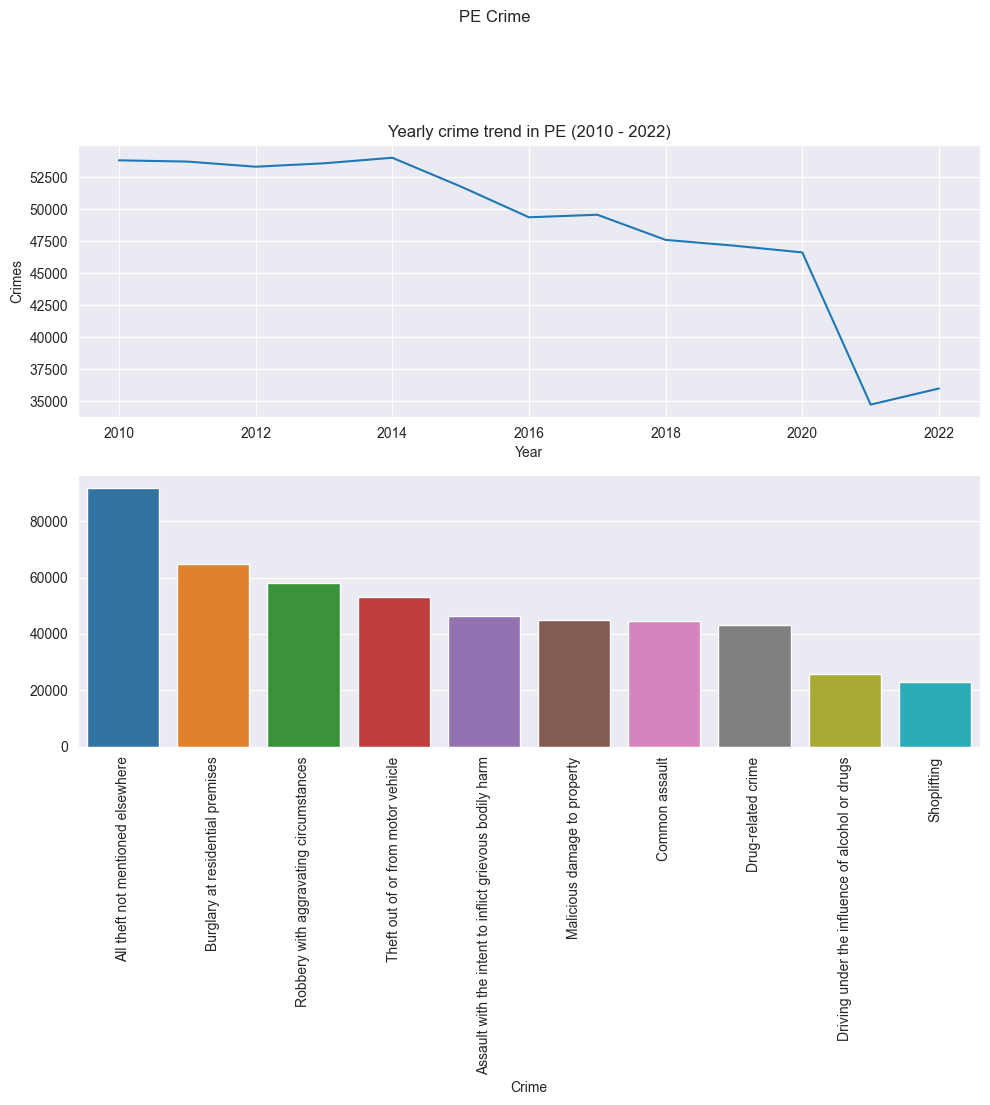

In [18]:
yearly_sum = df.groupby(['Year'])['Crimes'].sum() #Get yearly crime trends
top_crimes = df.groupby(['Crime'])['Crimes'].sum().sort_values(ascending=False)[:10] #Top 10 crimes in descending order

fig, axs = plt.subplots(2, figsize=(10, 10))
ax = sns.lineplot(yearly_sum, ax=axs[0]) #Visualisations
ax1 = sns.barplot(x=top_crimes.index, y=top_crimes.values, ax=axs[1])

ax.set_title('Yearly crime trend in PE (2010 - 2022)')
ax1.set_xticks(range(0,len(top_crimes.index)), top_crimes.index, rotation=90) #Rotate by 90 degrees
plt.tight_layout()
plt.suptitle("PE Crime", y=1.1) #Main title
plt.show()

##### The above lineplot suggests that crime has gradually decreased in Port Elizabeth over the years, especially in 2020 - 2022. This drastic decrease in crimes could be due to the Covid-19 pandemic. The barplot suggests that the top three crimes in Port Elizabeth are thefts, residential burglaries, and robberies with aggravating circumstances.

#### Brief overview of Port Elizabeth crime trends according to crime category

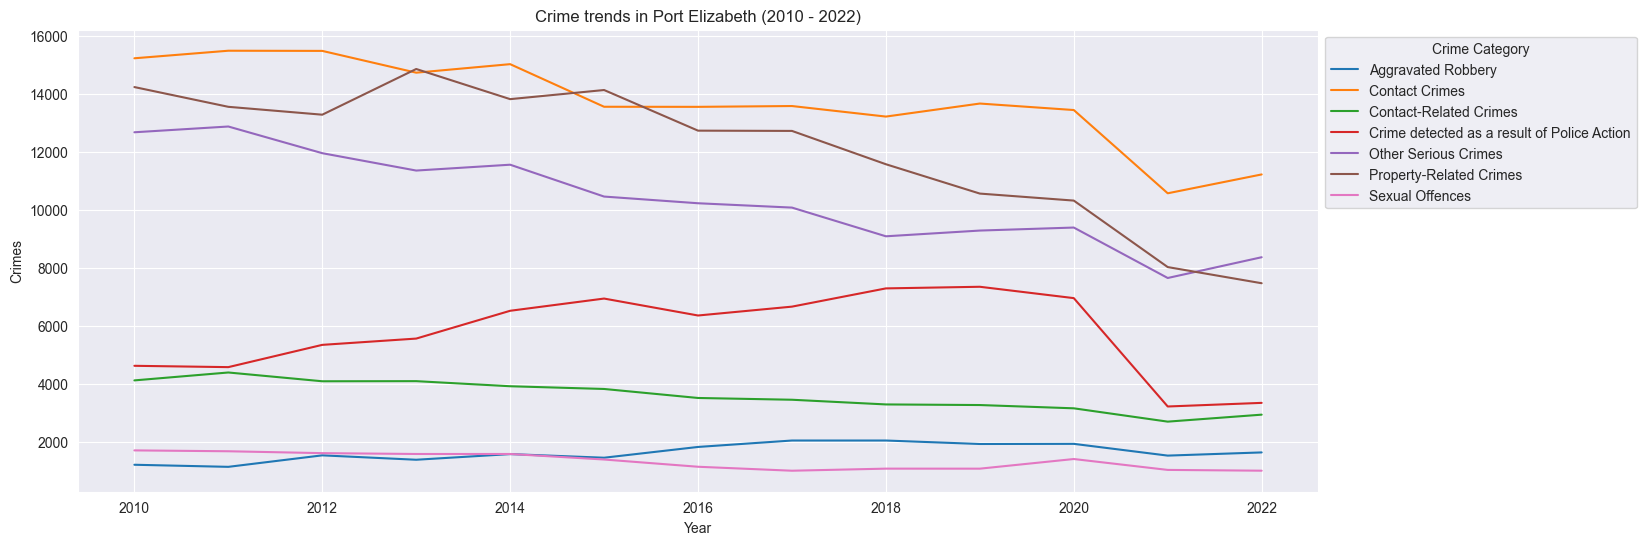

In [19]:
crimecat_summed = df.groupby(['Crime Category', 'Year'])['Crimes'].sum().reset_index() #Sum of each crime category per year

plt.figure(figsize=(16,6))
ax = sns.lineplot(crimecat_summed, x='Year', y='Crimes', hue='Crime Category') #Line plot of the 7 different crime categories
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1)) #Moves legend outside plot

plt.title('Crime trends in Port Elizabeth (2010 - 2022)')
plt.show()

##### The above lineplot suggests that within Port Elizabeth, contact crimes are decreasing, aggravated robberies are increasing, and sexual offences have maintained a similar trend over the years.

#### Interactive heatmap of crimes in Port Elizabeth

In [20]:
#Creating heatmap
heatmap = df.groupby(['Police Station'], observed=True)['Crimes'].sum().reset_index()
heatmap['Latitude'] = df['Latitude'].unique()
heatmap['Longitude'] = df['Longitude'].unique()
heatmap['size'] = heatmap['Crimes'] / 60

In [21]:
fig = px.scatter_mapbox(heatmap, lat="Latitude", lon="Longitude", hover_name="Police Station", hover_data=["Crimes"],
                        color="Crimes", color_continuous_scale=['Yellow', 'orange', 'red', 'maroon'], zoom=11, height=700, size='Crimes', size_max=30)
fig.update_layout(mapbox_style="carto-darkmatter", margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

##### The above interactive map depicts major hotspots as large red circles. These hotspots are identified in the following barplot. The larger/redder the circle, the more crimes were committed in that area.

### Static heatmap of Port Elizabeth crime hotspots

##### Create geodataframe

In [22]:
#A GeoDataFrame is a dataframe that accepts a geometry column (POINT pairs)
geo_df = gpd.GeoDataFrame(heatmap, crs = {'init': 'epsg:4326'}, geometry=[Point(xy) for xy in zip(heatmap['Longitude'], heatmap['Latitude'])])

c:\Users\user-pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



##### Plot

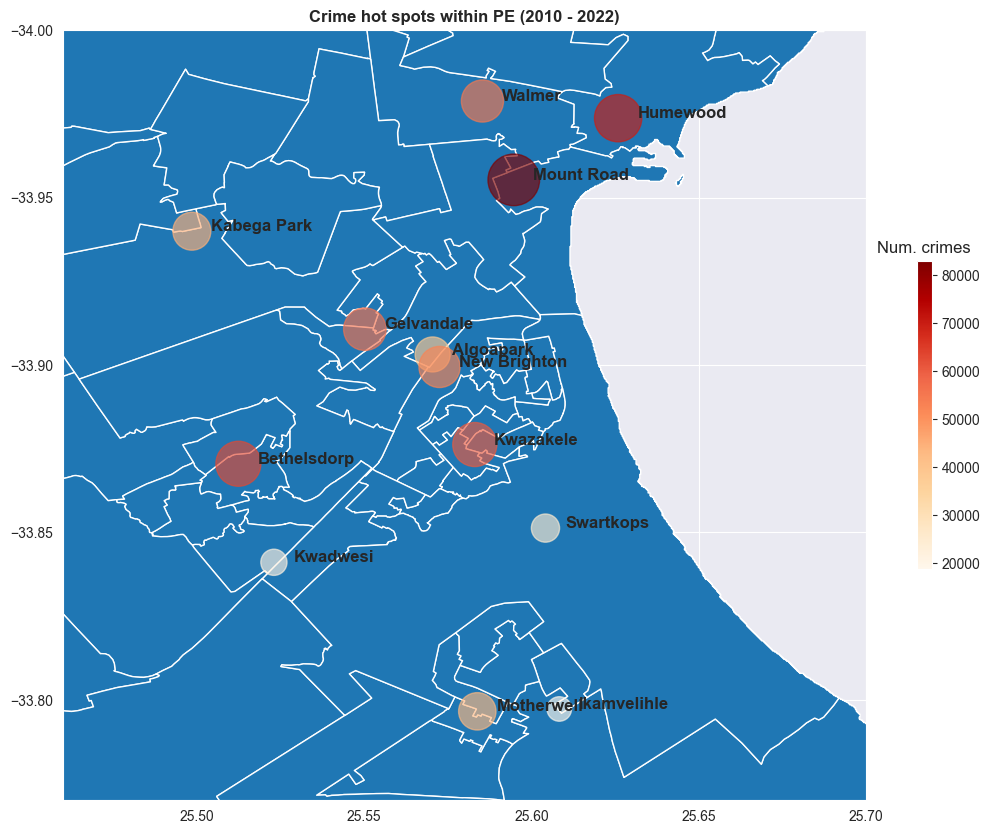

In [23]:
fig, ax = plt.subplots(figsize=(13,10)) #Cr

map = gpd.read_file("SAshape/gadm41_ZAF_4.shp") #Read in SA shape file
map.plot(ax=ax, aspect=1) #Plot the map of South Africa
geo_df.plot(aspect=1, column='Crimes', ax=ax, markersize='size', cmap='OrRd', legend=True, alpha=0.65, legend_kwds={'shrink': 0.4}) #Plot the latitude longitude pairs onto the same SA map.

ax.set_ylim([-33.77, -34]) #Zoom in on PE
ax.set_xlim([25.46, 25.7]) #Zoom in on PE

for x, y, label in zip(geo_df.geometry.x, geo_df.geometry.y, geo_df['Police Station']):
    ax.annotate(label, xy=(x, y), xytext=(14,0), textcoords="offset points", weight='bold', fontsize=12) #Label each hotspot

ax.get_figure().get_axes()[1].set_title("Num. crimes") #Legend title
plt.title('Crime hot spots within PE (2010 - 2022)', weight='bold')
plt.show()

#### Barplot of Top 10 hotspots in Port Elizabeth

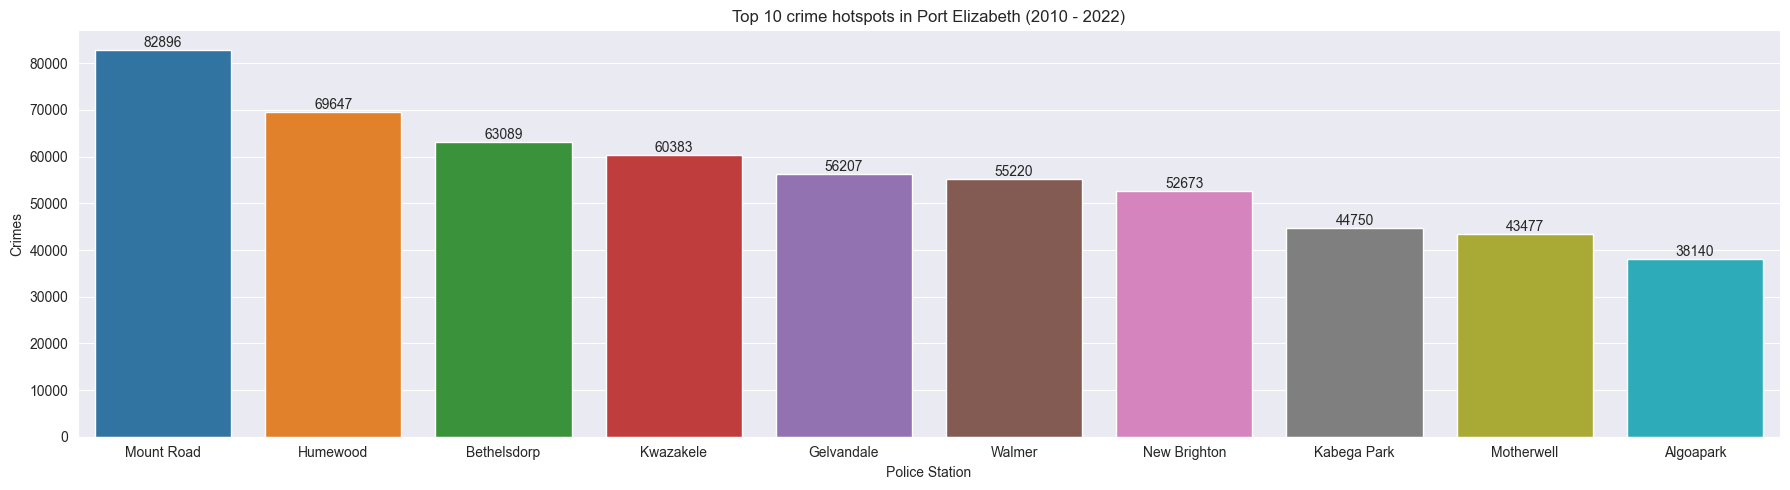

In [24]:
heatmap_top10 = heatmap.sort_values('Crimes', ascending=False)[:10]

plt.figure(figsize=(18,5))
ax = sns.barplot(heatmap_top10, x='Police Station', y='Crimes') #Barplot of top 10 crimes

for i in ax.containers:
    ax.bar_label(i,) #Depict crime count over each bar
    
plt.title("Top 10 crime hotspots in Port Elizabeth (2010 - 2022)")
plt.tight_layout()
plt.show()

##### According to the heatmap and barplot above, most crimes in Port Elizabeth between 2010 - 2022 were reported to these three police stations: Mount Road, Humewood, and Bethelsdorp.

In [25]:
df.groupby(['Crime Category'])['Crimes'].sum().sort_values(ascending=False)

Crime Category
Contact Crimes                                 178913
Property-Related Crimes                        157408
Other Serious Crimes                           135058
Crime detected as a result of Police Action     74759
Contact-Related Crimes                          46726
Aggravated Robbery                              21172
Sexual Offences                                 17224
Name: Crimes, dtype: int64

#### There are 30 unique classes of crimes with 7 unique crime categories

### <u>Machine Learning</u>

#### Import

In [26]:
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from catboost import CatBoostClassifier, cv, Pool
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.naive_bayes import GaussianNB
from time import process_time
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from joblib import dump, load
from sklearn.compose import ColumnTransformer

#### Data aquisition

In [27]:
X = df.drop(['Police Station', 'Latitude', 'Longitude'], axis=1)
y = df['Police Station']

#### Sampling/split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

#### Categorical encoding

In [29]:
ct = ColumnTransformer(transformers=[('encoder', OrdinalEncoder(), [0, 2])], remainder='passthrough')
X_train_transformed = ct.fit_transform(X_train)
X_test_transformed = ct.transform(X_test)

#### Hyperparameter space

In [30]:
rand_grid = { #Random forest grid
 'min_samples_leaf': [1, 2, 3],
 'min_samples_split': [2, 3, 4],
 'n_estimators': [20, 50, 100, 200]}

decision_grid = { #Decision tree grid
    'criterion': ['gini', 'entropy'],        
    'splitter': ['best', 'random'],           
    'min_samples_split': [2, 5, 10],         
    'min_samples_leaf': [1, 2, 4],           
    'max_features': ['sqrt', 'log2'],                  
}

NB_grid = { #Gaussian Naive Bayes grid
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
}

knn_grid = { #k-NN grid
    'n_neighbors': [3, 5, 7, 9],        
    'weights': ['uniform', 'distance'], 
    'p': [1, 2],                        
    'metric': ['euclidean', 'manhattan']
}

ada_grid = { #AdaBoost grid
    'n_estimators': [50, 100, 200],  
    'learning_rate': [0.1, 0.5, 1.0]
}

cat_grid = { #CatBoost grid
    'iterations': 1000,      
    'learning_rate': 0.05, 
    'depth': 6,                  
    'l2_leaf_reg': 5,             
    'border_count': 64,
    "loss_function": "MultiClass"
}

xg_grid = { #XGBoost grid
        'min_child_weight': [1, 5, 10],
        'gamma': [0, 0.5, 1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [4, 5, 6]
        }

space = [rand_grid,decision_grid, cat_grid, ada_grid, NB_grid, knn_grid, xg_grid] #List of grids


#### Algorithm training

In [31]:
#Handles the results dataframe
def appendToDf(avg, std, y_pred, y_test, name, results):
    '''Groups the results of each classifier into a pandas dataframe'''

    avg = round(avg.mean()*100, 2) #Average and standard deviation of CV results
    std = round(std.mean()*100,2)
    accuracy = round(accuracy_score(y_test, y_pred)*100,2) #Get accuracy, precision, recall, and f1-score of each model
    precision = round(precision_score(y_test, y_pred, average="weighted")*100,2)
    recall = round(recall_score(y_test, y_pred, average="weighted")*100,2)
    f1 = round(f1_score(y_test, y_pred, average="weighted")*100,2)
    print(f"{name} CV Test {avg}% std: {std}") if name != 'CatBoostClassifier' else print(f"{name} CV Test loss {avg} std: {std}")#Train score CV results
    print(f"{name} test accuracy score: {accuracy}%") #Accuracy on test set
    return pd.concat([results, pd.DataFrame({"Name":[name], "Accuracy":[accuracy], "Precision":[precision], "Recall":[recall], "F1" : [f1]})]) #Return updated dataframe

In [36]:
#Handles the training, hyperparameter tuning, validation, and testing of models
def modelEvaluation(clf, scoring):
    '''Trains each model using 5-fold CV and RandomizedSearch for hyperparameter tuning. 
    Pickles each model for later use. Returns dataframe of metrics per model'''

    cval = KFold(n_splits=5) #5-fold CV
    results = pd.DataFrame({}, columns=["Name", "Accuracy", "Precision", "Recall", "F1"]) #Create empty dataframe
    with open('Models/params.txt', 'w') as f: #Write model with best parameters to text file
        for i in range(len(clf)): #Loop through each model
            start = process_time() #Begin process timer
            name = clf[i].__class__.__name__ #Get model name
            model = clf[i]
            search = None
            
            if name == 'CatBoostClassifier': #CatBoostClassifier does not seem to work with RandomizedSearchCV.
                model.fit(X_train, y_train, cat_features=[0,2]) #CatBoost can handle categorical encoding on its own
                y_pred = model.predict(X_test)
                cv_data = Pool(data=X_train, label=y_train, cat_features=[0,2]) #CatBoost's internal data structure Pool is needed for CV
                scores = cv(cv_data, space[i], fold_count=5, verbose=False) #Get CV of multiclass losses
                avg = scores['test-MultiClass-mean'] #These are not CV mean accuracies, but rather the losses
                std = scores['test-MultiClass-std']
                results = appendToDf(avg, std, y_pred, y_test, name, results) #Add results to dataframe

            elif name == 'XGBClassifier':  #n_jobs = 1 because XGBoost is already using the GPU to train each model
                le = LabelEncoder() #XGBoost requires that y is first encoded
                y_train_transformed = le.fit_transform(y_train)
                y_test_transformed = le.transform(y_test)
                search = RandomizedSearchCV(model, space[i], n_jobs=1, n_iter=5, refit=True, scoring=scoring, cv=cval, random_state=42)
                search.fit(X_train_transformed, y_train_transformed)
                y_pred = search.predict(X_test_transformed)
                avg = search.cv_results_['mean_test_score']
                std = search.cv_results_['std_test_score']
                results = appendToDf(avg, std, y_pred, y_test_transformed, name, results) #Add results to dataframe

            else: #Run using 7 cores
                search = RandomizedSearchCV(model, space[i], n_jobs=7, n_iter=5, refit=True, scoring=scoring, cv=cval, random_state=42)
                search.fit(X_train_transformed, y_train) #Using encoded features
                y_pred = search.predict(X_test_transformed)
                avg = search.cv_results_['mean_test_score']
                std = search.cv_results_['std_test_score']
                results = appendToDf(avg, std, y_pred, y_test, name, results) #Add results to dataframe

            f.write(f'{name}: {search.best_params_}') if name != 'CatBoostClassifier' else f.write(f'{name}: {model.get_params()}') #Write best parameters per model to file
            dump(search.best_estimator_, f'Models/{name}.joblib') if name != 'CatBoostClassifier' else dump(model, f'Models/{name}.joblib') #Pickle each model for later use
            
            end = process_time() #Record total processing time taken per model
            print(f"Total time taken: {end-start}s\n")
        
    return results.reset_index(drop=True)

In [37]:
#Using the following 7 classifiers.  
clf = [RandomForestClassifier(random_state=42),
       DecisionTreeClassifier(random_state=42),
       CatBoostClassifier(random_state=42, allow_writing_files=False, task_type="GPU", devices='0:1', iterations=1000, logging_level='Silent'), #Runs on GPU
      AdaBoostClassifier(random_state=42),
      GaussianNB(),
       KNeighborsClassifier(),
       xgb.XGBClassifier(objective='multi:softmax', random_state=42, subsample = 0.8, min_child_weight = 10, max_depth = 6, gamma = 0, colsample_bytree = 1, nthread = 3, tree_method = "hist", device = "cuda", verbosity=0) #Runs on GPU
       ]

#### Putting it all together

In [38]:
import warnings
warnings.filterwarnings('ignore') #AdaBoost model results in precision warnings as there are labels with no predicted samples. Surpress these.

d = modelEvaluation(clf, 'accuracy') #Run tests
d.to_csv('Models/results.csv', index=False) #Save results to CSV

RandomForestClassifier CV Test 15.39% std: 0.99
RandomForestClassifier test accuracy score: 15.09%
Total time taken: 0.984375s

DecisionTreeClassifier CV Test 13.48% std: 0.99
DecisionTreeClassifier test accuracy score: 13.31%
Total time taken: 0.03125s

Training on fold [0/5]

bestTest = 2.439360419
bestIteration = 501

Training on fold [1/5]

bestTest = 2.435735894
bestIteration = 830

Training on fold [2/5]

bestTest = 2.457146513
bestIteration = 597

Training on fold [3/5]

bestTest = 2.459125332
bestIteration = 910

Training on fold [4/5]

bestTest = 2.437783921
bestIteration = 807

CatBoostClassifier CV Test loss 247.12 std: 0.99
CatBoostClassifier test accuracy score: 12.03%
Total time taken: 196.5s

AdaBoostClassifier CV Test 8.71% std: 0.74
AdaBoostClassifier test accuracy score: 10.75%
Total time taken: 0.515625s

GaussianNB CV Test 10.03% std: 0.77
GaussianNB test accuracy score: 8.28%
Total time taken: 0.03125s

KNeighborsClassifier CV Test 12.64% std: 0.87
KNeighborsClassi

#### Results

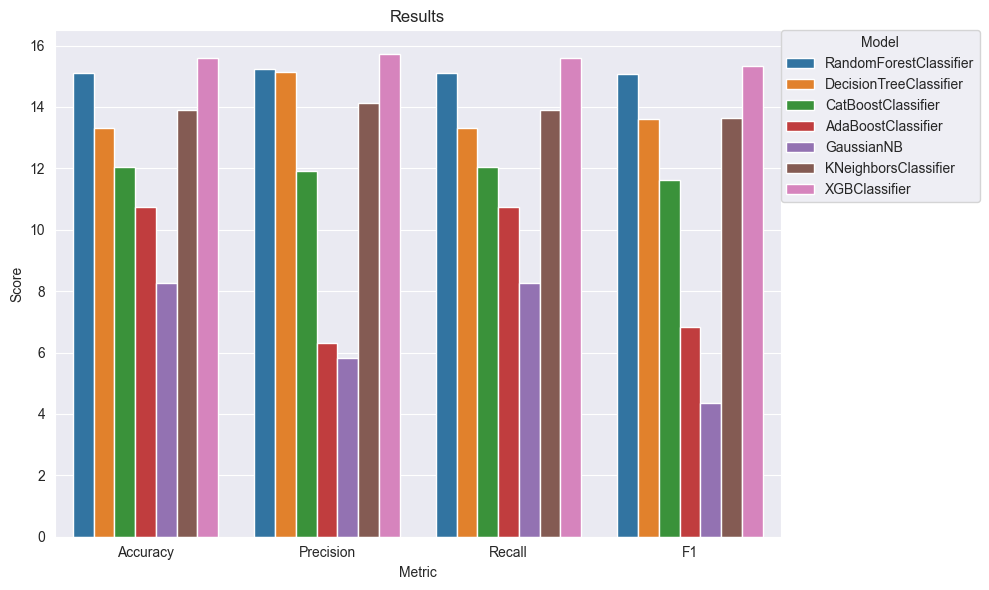

In [40]:
melted_df = d.melt(id_vars="Name", value_vars=["Accuracy", "Precision", "Recall", "F1"], var_name="Metric")

# Create result barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=melted_df, x="Metric", y="value", hue="Name")
plt.title("Results")
plt.xlabel("Metric")
plt.ylabel("Score")
plt.legend(title="Model", loc=2, bbox_to_anchor=(1, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

### <u>Results and Discussion</u>

#### EDA

......

#### Machine Learning

The structure of the SAPS dataset is vastly different to that of the Boston and Chicago crime datasets. There are significantly less features in this dataset, resulting in 7 unique features as compared to the Chicago dataset which has 23 features. Furthermore, crime records are aggregated per year into counts where Boston and Chicago list crime records per incident. Lastly, the number of data points is also vastly reduced. Filtering for Port Elizabeth records in the SAPS dataset results in around 5068 records from 2010 - 2022, well the Chicago dataset has over 1,000,000 data points. 

This experiment aimed to predict the various police stations within Port Elizabeth, given the type of crime committed, the number of crimes	committed that year, the crime category, and the year the crime took place. The reason for this feature selection is due to the high correlation between latitude, longitude, and police station. It is futile to predict the police station of a crime when given the coordinates of the police station, as these coordinates directly predict the police station. These significant differences and the differences mentioned above play a role in the results achived, which will be discussed in the following section.

<table border="1" class="dataframe">
 <caption style='margin:20px;background-color:cyan; color:black';><b>Table 1: Performance metrics of various classifiers on the SAPS dataset</b></caption>
  <thead>
    <tr style="text-align: right;">
      <th>Ranking</th>
      <th>Name</th>
      <th>Accuracy</th>
      <th>Precision</th>
      <th>Recall</th>
      <th>F1</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>2</th>
      <td>RandomForestClassifier</td>
      <td>15.09</td>
      <td>15.22</td>
      <td>15.09</td>
      <td>15.07</td>
    </tr>
    <tr>
      <th>4</th>
      <td>DecisionTreeClassifier</td>
      <td>13.31</td>
      <td>15.13</td>
      <td>13.31</td>
      <td>13.60</td>
    </tr>
    <tr>
      <th>5</th>
      <td>CatBoostClassifier</td>
      <td>12.03</td>
      <td>11.91</td>
      <td>12.03</td>
      <td>11.61</td>
    </tr>
    <tr>
      <th>6</th>
      <td>AdaBoostClassifier</td>
      <td>10.75</td>
      <td>6.32</td>
      <td>10.75</td>
      <td>6.84</td>
    </tr>
    <tr>
      <th>7</th>
      <td>GaussianNB</td>
      <td>8.28</td>
      <td>5.81</td>
      <td>8.28</td>
      <td>4.36</td>
    </tr>
    <tr>
      <th>3</th>
      <td>KNeighborsClassifier</td>
      <td>13.91</td>
      <td>14.13</td>
      <td>13.91</td>
      <td>13.65</td>
    </tr>
    <tr>
      <th>1</th>
      <td>XGBClassifier</td>
      <td>15.58</td>
      <td>15.71</td>
      <td>15.58</td>
      <td>15.32</td>
    </tr>
  </tbody>
</table>

All models used performed poorly on the SAPS dataset when predicting police station. The best model was eXtreme gradient boosting (XGB), with an accuracy and F1-score of 15.58% and 15.32%, respectively. The worst model was Gaussian Naive Bayes, yielding an accuracy and F1-score of 8.28% and 4.36%, respectively. The remaining models all performed with an accuracy range of 10%-15%. Precision scores ranged from 5.81% for Gaussian Naive Bayes, to 15.71% for XGB. Recall scores ranged from 8.28% for Gaussian Naive Bayes, to 15.58% for XGB.

Given the above results, a robust crime forecasting system cannot be developed for South Africa using the SAPS dataset. The same models used on the Chicago and Boston crime datasets achieved accuracies up to 88.4%, whereas these models achieve accuracies up to 15.58% using the SAPS dataset. Additionally, F1-scores of up to 88.28% were achieved using the Boston dataset, but the SAPS dataset yielded F1-scores of up to 15.32%.

## <center><b>Thanks for reading!</b>

Do I have to cite Michael still, as I am using his CSV file?